# Estratégia long-short baseada em trees ensembles
**Escrito por**: Enrique Quintslr (https://github.com/enriquemq/)  
 <font size="2"> *Qualquer crítica, dúvida ou sugestão, sinta-se a vontade para me contactar pelo meio de sua preferência.*</font> 

## 1. Introdução

A ideia desse notebook é utilizar métodos de machine learning para montar um portfólio long-short com ações que compõem o índice Bovespa. O notebook é inspirado em algumas ideias apresentadas no seguinte artigo:

*   Kraus et al, **Deep neural networks, gradient-boosted trees,
random forests: Statistical arbitrage on the S&P 500**, European Journal of Operational Research. 
Volume 259, Issue 2, 1 June 2017, Pages 689-702
https://www.sciencedirect.com/science/article/abs/pii/S0377221716308657

Importante ressaltar que o conteúdo apresentado nesse notebook está muito mais próximo de um exercício do que de um projeto de pesquisa. Os dados utilizados, tanto pela fonte quanto pela quantidade, não são recomendados para uso profissional. O intuito do material é apenas obter insights sobre o comportamento de modelos de machine learning e apresentar **de forma introdutória** como técnicas de ML podem vir a ser incorporadas no processo de pesquisa e alocação de ativos.



   

---------
---------
## 2. Metodologia

**Base de dados:**  
O Universo de ativos considerado são as ações que faziam parte do índice Bovespa no dia 23/10/2020, excluindo aquelas que apresentaram erros na extração de dados.
Os dados de preços das ações e os valores do Ibovespa são extraídos da base do Yahoo Finance e compreendem o período de 26/10/2015 até 23/10/2020. Deste corte temporal, 70% é separado para base de treino e 30% para base de teste de forma cronológica. Ou seja, a base de treino vai do início da amostra até o dia 09/08/2019 e a base de teste segue a partir dessa data até o fim da amostra.  
Os dados dos portfólios de fatores de risco são obtidos do site do NEFIN (http://nefin.com.br/).  


**Features:**  
Para cada ação e cada dia da amostra, são calculadas as seguintes variáveis preditoras:
$$\frac{p_{t} - p_{t-i}}{p_{t-i}}, i \in \{1, 2, 3, \dots, 19, 20, 40, 60,  \dots, 240\}$$
onde $p_t$ é o preço de fechamento da ação no dia $t$.  
  

**Classification Target**:  
Para cada ação e cada dia da amostra, o objetivo do modelo é prever se o preço de fechamento do dia seguinte será maior que o preço de fechamento do dia atual. Ou seja:
$$y = \begin{cases}
        1 & p_{t+1} > p_t \\
        0 & p_{t+1} \leq p_t
      \end{cases}$$

**Modelos**:  
Para cada ação, são treinados individualmente dois modelos: Random Forest e Gradient Boosted Trees. Os hiperparâmetros dos modelos são baseados no artigo de referência.

**Formação dos Portfólios**:  
Para cada dia do período de teste, é usada a média entre as probabilidades de alta prevista pelos dois modelos para ranquear as ações. O portfólio long only é formado pelas **n** primeiras ações do ranking com pesos iguais e o portfólio short only é formado pelas n últimas ações também com pesos iguais. Naturalmente, o retorno do portfólio long short é dado pelo retorno do portfólio long only subtraído pelo retorno das ações do portfólio short only.  
Seguindo o mesmo padrão da literatura de formação dos portfólios teóricos, **n** é escolhido de forma que cada porfólio direcional seja composto por $\frac{1}{3}$ das ações disponíveis.

**Análise dos resultados:**  
Em posse da série dos retornos dos portfólios, calculamos as seguintes métricas de performance: retorno anualizado, desvio padrão, naive sharpe ratio (naive porque não subtraio risk free rate) e drawdown máximo. Com isso, as métricas dos portfólios são comparados com a performance do ibovespa no mesmo período. Por fim, é feita a regressão dos portfólios com os portfólios teóricos de fatores de risco usuais a fim de obter uma maior intuição sobre o funcionamento dos modelos.


---------------
-----------------
## 3. Código

### 3.1 Preliminares

In [ ]:
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from statsmodels.formula.api import ols


In [ ]:
# Universo de ações
tickers = ['ABEV3.SA', 'AZUL4.SA', 'B3SA3.SA', 'BBAS3.SA', 'BBDC4.SA',
           'BBSE3.SA', 'BEEF3.SA', 'BPAC11.SA', 'BRAP4.SA', 'BRDT3.SA', 
           'BRFS3.SA', 'BRKM5.SA', 'BRML3.SA', 'BTOW3.SA', 'CCRO3.SA', 
           'CIEL3.SA', 'CMIG4.SA', 'COGN3.SA', 'CPFE3.SA', 'CRFB3.SA',
           'CSAN3.SA', 'CSNA3.SA', 'CVCB3.SA', 'CYRE3.SA', 'ECOR3.SA',
           'EGIE3.SA', 'ELET3.SA', 'ELET6.SA', 'EMBR3.SA', 'ENBR3.SA', 
           'ENGI11.SA', 'EQTL3.SA', 'FLRY3.SA', 'GGBR4.SA', 'GNDI3.SA',
           'GOAU4.SA', 'GOLL4.SA', 'HAPV3.SA', 'HGTX3.SA', 'HYPE3.SA',
           'IGTA3.SA', 'IRBR3.SA', 'ITSA4.SA', 'ITUB4.SA', 'JBSS3.SA', 
           'KLBN11.SA', 'LAME4.SA', 'LREN3.SA', 'MGLU3.SA', 'MRFG3.SA',
           'MRVE3.SA', 'MULT3.SA', 'NTCO3.SA', 'PETR3.SA', 'PETR4.SA',
           'QUAL3.SA', 'RADL3.SA', 'RAIL3.SA', 'RENT3.SA', 'SANB11.SA', 
           'SBSP3.SA', 'SULA11.SA', 'SUZB3.SA', 'TAEE11.SA', 'TIMP3.SA',
           'TOTS3.SA', 'UGPA3.SA', 'USIM5.SA', 'VALE3.SA', 'VIVT4.SA', 
           'VVAR3.SA', 'WEGE3.SA', 'YDUQ3.SA']

In [ ]:
# Baixando os dados do Yahoo
keys = []
for ticker in tickers:
    name = ticker[:-3]
    keys.append(name)

dfs = {}
for i in range(len(keys)):
  dfs[keys[i]] = web.DataReader(tickers[i], data_source='yahoo')  

# Carregando bases de dados
dfs_factors = obter_risk_factors_nefin() # função que baixa os dados do site nefin
base_retornos_futuros = pd.read_csv('caminho do arquivo')

------------------
------------------
### 3.2 Treinando modelos e obtendo previsões

In [ ]:
# Função para preparar as base de dados que serão usadas para treinar modelos e obter probabilidades

def preparar_base(ticker, prop_treino, dfs):

  df = dfs[ticker[:-3]]                                                             
  df = pd.DataFrame(df['Adj Close'])
  
  for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,15,16,17,18,19,20,40,60,80,100,120,140,160,180,200,220,240]:
    df['lag{}'.format(i)] = (df['Adj Close'] - df['Adj Close'].shift(i)) / df['Adj Close'].shift(i)
  
  df['Target'] = df['Adj Close'].shift(-1) > df['Adj Close']
  df = df.dropna()
  X = df.iloc[:,1:-1]
  Y = df['Target']
  N_split = round(len(Y)*0.7)
  X_train, Y_train = X[:N_split], Y[:N_split] 
  X_test, Y_test = X[N_split:], Y[N_split:]
  print('Base preparada.')
  print('Tamanho amostra de treino:', N_split-1)
  print('Tamanho amostra de teste:', len(Y_test))
  
  return {'X_train': X_train, 'Y_train': Y_train, 'X_test': X_test, 'Y_test': Y_test}

In [ ]:
# Função para obter as probabilidades estimadas do ensemble

def obter_probabilidades(X_train, Y_train, X_test):

  #Boosting
  boost = GradientBoostingClassifier(n_estimators = 100, learning_rate= 0.01)
  boost.fit(X_train, Y_train)
  probs_boost = boost.predict_proba(X_test)[:,1]

  #Random Forest
  rf = RandomForestClassifier(n_estimators = 100)
  rf.fit(X_train, Y_train)
  probs_rf = rf.predict_proba(X_test)[:,1]

  mean_probs = np.mean([probs_boost, probs_rf], axis = 0)

  return mean_probs

In [ ]:
# Loop principal da sessão. Treina os modelos e obtêm as probabilidades estimadas.

# parâmetros:
prop_treino = 0.7

# variáveis auxiliares:
lista_probs = []
i = 1

# Loop para calcular as previsões de probabilidade de cada ação
for ticker in tickers:
  dados = preparar_base(ticker, prop_treino, dfs)
  if len(dados['Y_test']) < 1:                              
    print('Pulando ', ticker ,' por número insuficiente de dados!')
    i += 1
    continue
  probs = obter_probabilidades(dados['X_train'], dados['Y_train'], dados['X_test'])
  dados['X_test'][ticker[:-3]] = probs
  lista_probs.append(dados['X_test'].iloc[:,-1:])
  print('Probabilidades para ', ticker, ' calculadas com sucesso!')
  print('{} de {} iterações realizadas'.format(i , len(tickers)))
  i += 1

In [ ]:
# Juntando as séries de probabilidades em um único dataframe
base_probs = lista_probs[0]
for i in range(len(lista_probs)-1):
    base_probs = base_probs.merge(lista_probs[i+1], how = 'outer', on = 'Date')
base_probs = base_probs.sort_index()
base_probs = base_probs.dropna(axis = 0, thresh=len(tickers)*1/2) # Tirando datas com muitos NaNs

--------
--------
### 3.3 Backtest

In [ ]:
# Funções para cálculo de métricas de performance
def daily_to_annualized_returns(series):
  series = list(filter(lambda v: v==v, series))
  return  (1+(series[-1] - series[0])/series[0])**(252/len(series)) - 1 

def naive_sharpe_ratio(series): # Naive Sharpe Ratio pq é sem subtrair risk_free!
  series = list(filter(lambda v: v==v, series))
  return ((series[-1] - series[0])/series[0])/np.std(series)

def max_drawdown(series):
  series = list(series)
  drawdown = 0
  for i in range(len(series)):
    for j in range(i):
      d = (series[i] - series[j])/series[j]
      if d < drawdown:
        drawdown = d
  return abs(drawdown)

def performance_metrics(series):
  series = list(filter(lambda v: v==v, series))
  return [daily_to_annualized_returns(series),
          np.std(series), 
          naive_sharpe_ratio(series),
          max_drawdown(series),
          daily_to_annualized_returns(series)/max_drawdown(series)]


# Funções auxiliares para backtest
def montar_portfolio_long(base_probs, n_acoes):
  return pd.DataFrame(base_probs.columns.values[np.argsort(-base_probs.values, axis = 1)[:,:n_acoes]],
                      index = base_probs.index)
  
def montar_portfolio_short(base_probs, n_acoes):
  return pd.DataFrame(base_probs.columns.values[np.argsort(base_probs.values, axis = 1)[:,:n_acoes]],
                      index = base_probs.index) 
  
def calcular_retornos(base, base_probs, base_retornos_futuros, n_acoes, short = False):
  serie_retorno = []
  # Loop para popular as séries
  for date in base_probs.index:
    port = np.array(base.loc[date, :])
    port_retornos = base_retornos_futuros.loc[date, port]
    if short == True:
      retorno = (-1)*np.sum(port_retornos)/n_acoes
    else:
      retorno = np.sum(port_retornos)/n_acoes
    serie_retorno.append(retorno)
  return serie_retorno

# Função principal!
def backtest(base_retornos_futuros, base_probs, n_acoes):
     
     # Montando portfolios
     base_long = montar_portfolio_long(base_probs, n_acoes)
     base_short = montar_portfolio_short(base_probs, n_acoes)
     
     # Calculando retorno dos portfolios
     serie_retorno_long = calcular_retornos(base_long, base_probs, base_retornos_futuros, n_acoes,  short = False)
     serie_retorno_short = calcular_retornos(base_short, base_probs, base_retornos_futuros, n_acoes, short = True)
     
     # Calculando retornos acumulados
     serie_retorno_long.insert(0, 0)
     serie_retorno_short.insert(0,0)
     serie_retorno_long_short = np.array(serie_retorno_long) + np.array(serie_retorno_short) # Long Short

     serie_retorno_long = np.cumprod(np.array(serie_retorno_long) + 1)
     serie_retorno_short = np.cumprod(np.array(serie_retorno_short) + 1)
     serie_retorno_long_short = np.cumprod(np.array(serie_retorno_long_short) + 1)
     
     # Plotando resultado:
     fig1, ax1 = plt.subplots()
     ax1.plot(base_long.index ,serie_retorno_long[:-1], label = 'long only')
     ax1.plot(base_short.index, serie_retorno_short[:-1], label = 'short only')
     ax1.plot(base_long.index, serie_retorno_long_short[:-1], label = 'long short')
     ax1.set_title('Retorno acumulado dos portfolios')
     ax1.legend()
     
     # Comparando com benchmark
     ibov = web.DataReader('^BVSP', data_source='yahoo')
     ibov['Adj Close']
     ibov_ret = (ibov['Adj Close'] - ibov['Adj Close'].shift(1)) / ibov['Adj Close'].shift(1)
     ibov_ret_futuro = ibov_ret.shift(-1) 

     # Serie Retorno IBOV saindo do 1 para poder comparar
     serie_retorno_ibov = []
     for date in base_long.index:
         serie_retorno_ibov.append(ibov_ret_futuro[date])
     serie_retorno_ibov.insert(0,0)
     serie_retorno_ibov = np.cumprod(np.array(serie_retorno_ibov) + 1)
     
     # Comparar long only com ibov
     fig2, ax2 = plt.subplots()
     ax2.plot(base_long.index ,serie_retorno_long[:-1], label = 'long only')
     ax2.plot(base_long.index, serie_retorno_ibov[:-1], label = 'ibov')
     ax2.set_title('Long-Only vs. Ibov')
     ax2.legend()
     
     # Printando métricas dos resultados
     series = {'long only': serie_retorno_long,
          'short only': serie_retorno_short,
          'long-short': serie_retorno_long_short,
          'ibov': serie_retorno_ibov}
     
     perf_metrics = pd.DataFrame(index=['Annualized Return', 'Std Dev', 'Naive Sharpe Ratio', 'Max Drawdown', 'Calmar Ratio']) 
     
     for key in series.keys():
        perf_metrics[key] = performance_metrics(series[key])
    
     print(perf_metrics)

     # Regressao com Fama-Factors
     base_regressao = pd.DataFrame(serie_retorno_long[:-1], index = base_long.index)
     base_regressao.columns = ['long_only']
     base_regressao['long_short'] = serie_retorno_long_short[:-1]
     base_regressao = (base_regressao - base_regressao.shift(1))/base_regressao
     for key in dfs_factors.keys():
       base_regressao = base_regressao.merge(dfs_factors[key], how = 'inner', on = 'Date')
     base_regressao = base_regressao.dropna()

     model = ols("long_only ~ Rm_minus_Rf + SMB + HML + WML + IML", base_regressao).fit()
     print('')
     print('----------')
     print('Regressão Long Only')
     print(model.summary())

     model = ols("long_short ~ Rm_minus_Rf + SMB + HML + WML + IML", base_regressao).fit()
     print('')
     print('----------')
     print('Regressão Long-Short')
     print(model.summary())

                    long only  short only  long-short      ibov
Annualized Return    0.043335   -0.109098    0.110213 -0.022074
Std Dev              0.130426    0.112604    0.058732  0.118301
Naive Sharpe Ratio   0.399875   -1.148148    2.272761 -0.222387
Max Drawdown         0.509436    0.366915    0.160897  0.468158
Calmar Ratio         0.085065   -0.297339    0.684993 -0.047150

----------
Regressão Long Only
                            OLS Regression Results                            
Dep. Variable:              long_only   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     777.9
Date:                Sat, 24 Oct 2020   Prob (F-statistic):          6.45e-153
Time:                        02:33:52   Log-Likelihood:                 884.31
No. Observations:                 263   AIC:                            -1757.
Df Residuals:                  

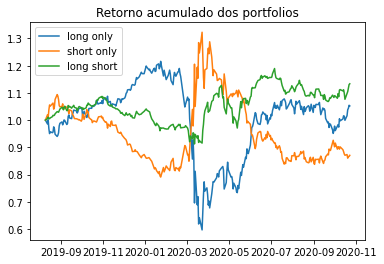

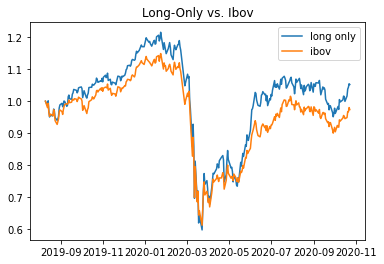

In [ ]:
#Usar 1/3 das acoes para o portfolio long e 1/3 para o short
n_acoes = round(base_probs.shape[1]/3)
backtest(base_retornos_futuros, base_probs, n_acoes)

------------------
------------------
## 4. Análise dos resultados e considerações finais
Analisando primeiro as métricas de performance do portfólio long only, observamos que superou o benchmark em retorno anualizado com contrapartida de um risco mais alto, tanto pelo desvio padrão quanto pelo max drawdown. Já o portfólio long short chama ainda mais atenção com um retorno anualizado de 11% e desvio padrão consideravelmente menor (o que é esperado de um portfólio long short).  

Agora observando os coeficientes das regressões do portfólio long only, duas observações chamam atenção. A primeira é o market beta de 1,23 e estatisticamente significativo, com isso temos uma explicação para a maior volatilidade observada em comparação com o benchmark. Segundo, usando um threshold de 0.1, temos que o portfólio apresenta alfa estatisticamente significante e negativo. Adicionalmente, observamos que o único fator de risco (fora risco de mercado) que afeta o portfólio é o Small minus Big, o que mostra que o modelo não diversifica em relação a tamanho de empresas e concentra as alocações em ações de empresas relativamente menores.

Como esperado, a market beta do portfólio long short é relativamente baixo, mostrando que é parcialmente bem sucedido em mitigar risco de mercado. Além disso, assim como o long only, o portfólio long short também é positivamente correlacionado com o portfólio teórico de tamanho. Por outro lado, diferente do long only, apresenta coeficiente negativo e estatisticamente significativo em relação ao portfólio IML.
Por fim (**mas não menos importante**), o $R^2$ ajustado de 0.24 mostra que boa parte dos retornos do portfólio long short não são explicados pelos fatores de risco usuais, indicando que o portfólio gerado pelos modelos poderia ser útil para buscar retornos descorrelacionados com esses fatores.

Para finalizar, vale ressaltar novamente que o trabalho apresentado acima é apenas um exercício inicial. Uma análise a nível profissional deveria considerar mais modelos e features, fazer *tuning* dos hiperparâmetros, treinar e testar os modelos em contextos de mercado diferentes e utilizar um universo maior de ativos. **Especialmente**, ao não levar em conta os custos operacionais da estratégia (que tem rebalanceamento diário nas duas pontas!) os resultados referentes ao retorno anualizado e sharpe ratio não devem ser levados pelo seu valor de face. Por outro lado, o resultado da descorrelação do portfólio long short com os fatores de risco demonstra uma qualidade interessante do modelo que justificaria análises futuras mais aprofundadas.